In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
winedf = pd.read_csv('/content/drive/MyDrive/учеба/dataanal/nlp/winemag-data-130k-v2.csv')
winedf.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [5]:
winedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [6]:
#Попробуем найти  повторяющиеся описания Таковые имеются
winedf[winedf['description'].duplicated(keep = False)].sort_values('description').head(8)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
67614,67614,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
46540,46540,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,87,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge
119702,119702,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew
72181,72181,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,88,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew
73731,73731,France,"87-89 Barrel sample. A pleasurable, perfumed w...",Barrel sample,88,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,@vossroger,Château Lalande-Borie 2008 Barrel sample (Sai...,Bordeaux-style Red Blend,Château Lalande-Borie
100745,100745,France,"87-89 Barrel sample. A pleasurable, perfumed w...",Barrel sample,88,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,@vossroger,Château Lalande-Borie 2008 Barrel sample (Sai...,Bordeaux-style Red Blend,Château Lalande-Borie
73730,73730,France,87-89 Barrel sample. Minty aromas give lifted ...,Barrel sample,88,NaN,Bordeaux,Saint-Émilion,NaN,Roger Voss,@vossroger,Château Haut-Sarpe 2008 Barrel sample (Saint-...,Bordeaux-style Red Blend,Château Haut-Sarpe
100744,100744,France,87-89 Barrel sample. Minty aromas give lifted ...,Barrel sample,88,NaN,Bordeaux,Saint-Émilion,NaN,Roger Voss,@vossroger,Château Haut-Sarpe 2008 Barrel sample (Saint-...,Bordeaux-style Red Blend,Château Haut-Sarpe


In [7]:
#Удалим дубликаты, чтобы не засорять сет
winedf = winedf.drop_duplicates('description')

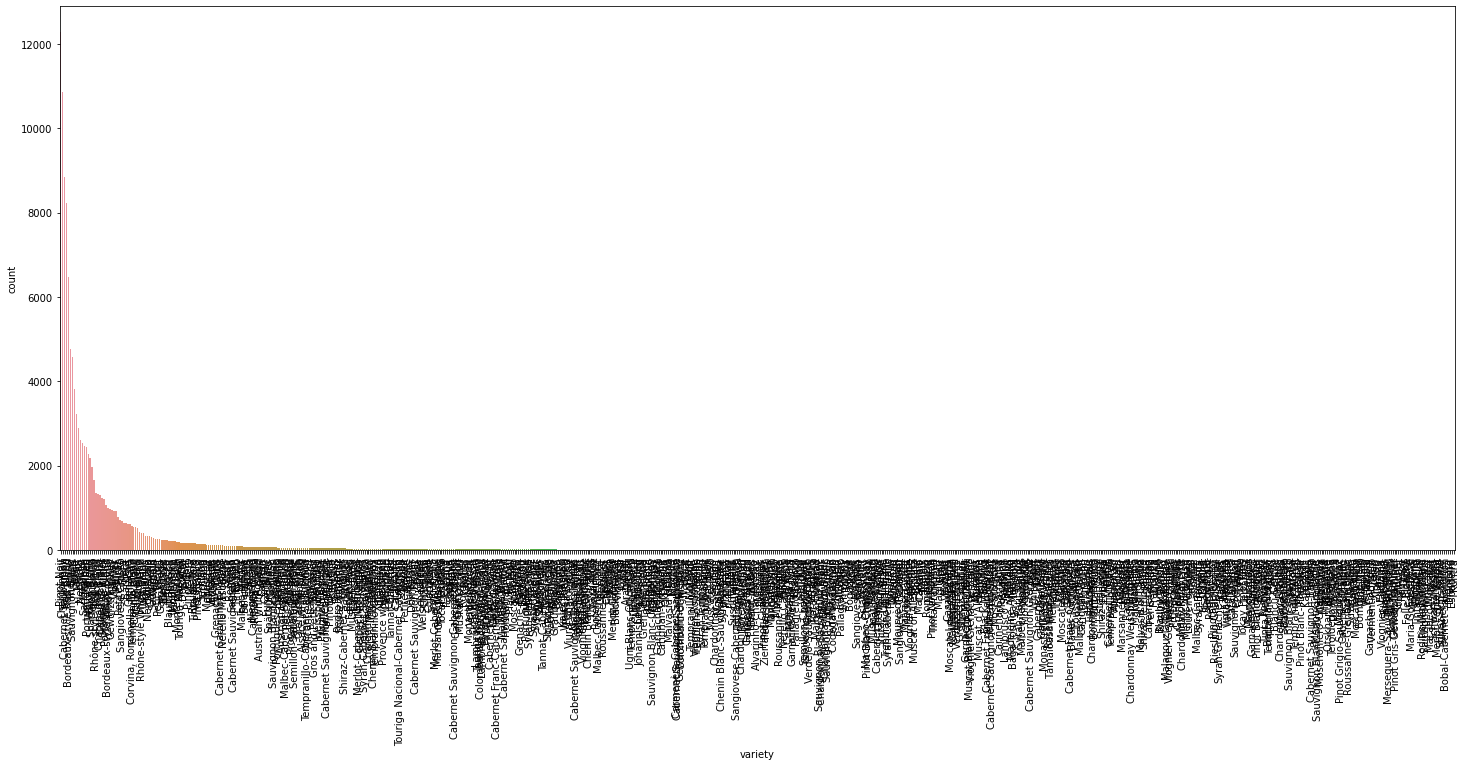

In [8]:
#Посторим график чтобы посмотреть на распределение вин
#Видов очень много
varieties = winedf['variety'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = winedf['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 90)
plt.show()

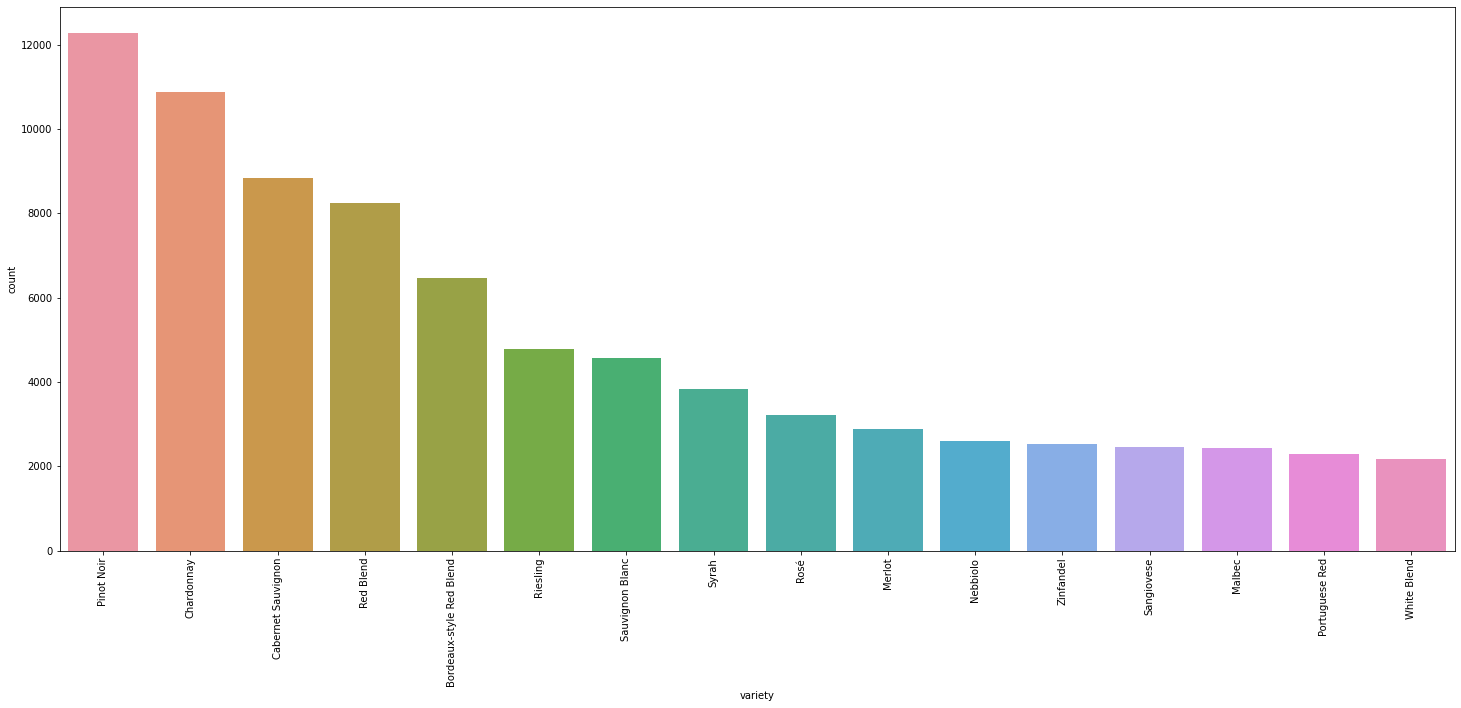

In [9]:
#Т.к. видов очень много, мы решили убрать те, которые реже всего встречаются
variety_df = winedf.groupby('variety').filter(lambda x: len(x) > 2000)
varieties = variety_df['variety'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = variety_df['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 90)
plt.show()

Осталось 16 разновидностей, с которыми будем работать

In [10]:
variety_df['variety'].unique()

array(['White Blend', 'Portuguese Red', 'Riesling', 'Pinot Noir',
       'Cabernet Sauvignon', 'Chardonnay', 'Malbec', 'Red Blend',
       'Merlot', 'Sauvignon Blanc', 'Sangiovese',
       'Bordeaux-style Red Blend', 'Rosé', 'Zinfandel', 'Syrah',
       'Nebbiolo'], dtype=object)

Препроцессинг текста

In [11]:
#уберем пунктуацию и стоп-слова английского языка
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)
desc = variety_df['description'].values
vectorizer = TfidfVectorizer(stop_words = stop_words)
X = vectorizer.fit_transform(desc)

In [12]:
word_features = vectorizer.get_feature_names()
word_features[550:575]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['abbot',
 'abbott',
 'abbreviated',
 'abc',
 'abeille',
 'abeja',
 'abel',
 'abernathy',
 'aberrant',
 'abetina',
 'abeyance',
 'abide',
 'abilio',
 'abilities',
 'ability',
 'abiouness',
 'able',
 'ably',
 'abnormal',
 'aboard',
 'abondante',
 'aboriginal',
 'abound',
 'abounds',
 'abouriou']

In [13]:
#Окончания слов не очень важны, поэтому добавим стемминг
stemmer = SnowballStemmer('english')
#и ограничим токены регулярками
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]
    #и не забыть перевести все в ловеркейс

In [14]:
vectorizer2 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize)
X2 = vectorizer2.fit_transform(desc)
word_features2 = vectorizer2.get_feature_names()
word_features2[:50]
#вот что получилось после добавления стемминга

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecati

["'s",
 "a'",
 "a'plenti",
 'aand',
 'aaron',
 'abacela',
 'abad',
 'abadia',
 'abandon',
 'abat',
 'abbess',
 'abbey',
 'abboccato',
 'abbot',
 'abbott',
 'abbrevi',
 'abc',
 'abeill',
 'abeja',
 'abel',
 'abernathi',
 'aberr',
 'abetina',
 'abey',
 'abid',
 'abil',
 'abilio',
 'abiou',
 'abl',
 'abli',
 'abnorm',
 'aboard',
 'abondant',
 'aborigin',
 'abound',
 'abouriou',
 'abov',
 'abovd',
 'abras',
 'abreu',
 'abri',
 'abrigo',
 'abroad',
 'abrupt',
 'abruzzo',
 'absberg',
 'absenc',
 'absent',
 'absolut',
 'absorb']

In [15]:
#и добавим ограничение на количество токенов
vectorizer3 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
X3 = vectorizer3.fit_transform(desc)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(inconsistent)


In [16]:
words = vectorizer3.get_feature_names_out ()
words[:50]

array(['abov', 'abund', 'accent', 'access', 'accompani', 'acid', 'acr',
       'ad', 'add', 'addit', 'afford', 'aftertast', 'age', 'ageabl',
       'ager', 'aggress', 'air', 'alcohol', 'allow', 'allspic', 'allur',
       'almond', 'alongsid', 'alreadi', 'alway', 'american', 'ampl',
       'ani', 'anis', 'anoth', 'ap', 'appeal', 'appear', 'appel', 'appet',
       'appl', 'approach', 'apricot', 'area', 'aroma', 'aromat', 'asian',
       'asphalt', 'assert', 'astring', 'attent', 'attract', 'auster',
       'away', 'backbon'], dtype=object)

 kMean разбиение на кластеры

In [17]:
kmeans = KMeans(n_clusters = 16, n_init = 5)
kmeans.fit(X3)

KMeans(n_clusters=16, n_init=5)

In [18]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print('cluster ' + str(num) + ') ' + ' '.join(words[word] for word in centroid))

cluster 0) light flavor wine fruit aroma finish cherri fresh bodi red
cluster 1) wine crisp acid textur fruit miner drink charact ripe fresh
cluster 2) chardonnay pineappl butter flavor oak vanilla toast tropic pear acid
cluster 3) like tast wine sweet flavor smell cherri fruit finish aroma
cluster 4) cabernet sauvignon merlot blend franc petit verdot black cherri syrah
cluster 5) berri aroma finish herbal flavor plum feel palat note fruit
cluster 6) blackberri flavor currant cherri tannin dri oak rich sweet soft
cluster 7) wine structur fruit tannin firm rich age dens ripe drink
cluster 8) palat alongsid tannin cherri aroma black offer berri spice red
cluster 9) pinot noir cherri raspberri silki cola flavor acid dri drink
cluster 10) wine fruit flavor cherri finish aroma oak spice tannin vineyard
cluster 11) fruiti wine drink readi attract soft acid red fruit ripe
cluster 12) black cherri palat nose pepper plum fruit flavor aroma dark
cluster 13) wood age wine fruit rich ripe drink ta

In [19]:
variety_df['cluster'] = kmeans.labels_

Посмотрим какие кластеры соответствуют каким винам в большей степени

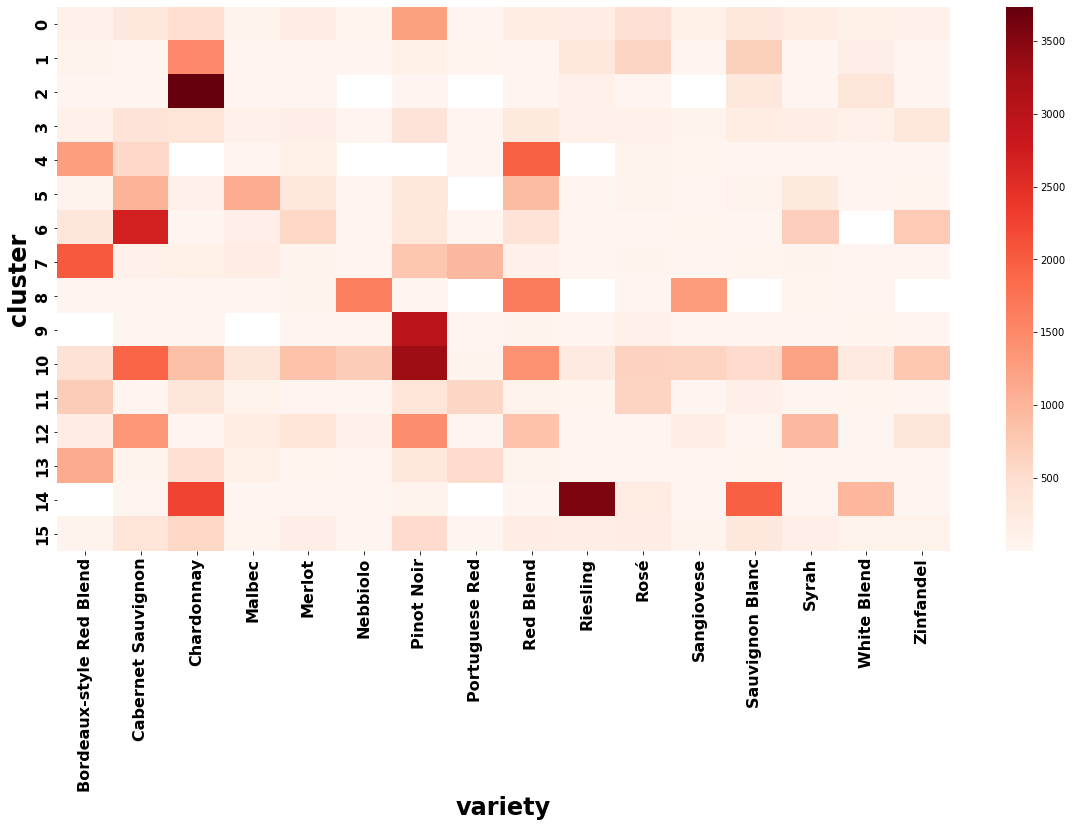

In [21]:
clusters = variety_df.groupby(['cluster', 'variety']).size()
fig2, ax2 = plt.subplots(figsize = (20, 10))
sns.heatmap(clusters.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

Получили 16 кластеров. некоторые (например 2 больше соотвествуют одному виду вина. Другие более универсальные. Это связано в том числе с тем что на разные виды вина описания содержат похожие слова, а также поскольку распределение не равномерное 